# Обучение с учителем: качество модели

**[Github](https://github.com/Mariiavs/supervised_learning)**

### Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. 

**Проблема:**

Активность покупателей начала снижаться, а привлекать новых клиентов уже не так эффективно. 

**Необходимо** удерживать активность постоянных клиентов с помощью персонализированных предложений. 

**Решение:**

1. Промаркировать уровень финансовой активности постоянных покупателей
2. Собрать необходимые данные по клиентам
3. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца
4. Включить в исследование дополнительные данные финансового департамента о прибыльности клиента
5. Выделить сегменты покупателей и разработать для них персонализированные предложения

**План работы:**
- [Загрузка данных](#step1)
- [Предобработка данных](#step2)
- [Исследовательский анализ данных](#step3)
- [Объединение таблиц](#step4)
- [Корреляционный анализ](#step5)
- [Использование пайплайнов](#step6)
- [Анализ важности признаков](#step7)
- [Сегментация покупателей](#step8)
- [Общий вывод](#step9)

### Импорт библиотек

In [1]:
# обновление scikit-learn
!pip install scikit-learn -U
!pip install scipy -U
!pip install numba -U

!pip install numpy==1.26.4
!pip install jinja2==3.1.2
!pip install matplotlib -U
!pip install seaborn -U

# установка библиотек
!pip install phik -q
!pip install shap -q

In [2]:
# работа с данными
import pandas as pd
import numpy as np

# построение графиков
import matplotlib.pyplot as plt
import seaborn as sns

# матрица корреляции
import phik

# разделение данных
from sklearn.model_selection import train_test_split

# класс pipeline
from sklearn.pipeline import Pipeline

# подготовка данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler)
from sklearn.compose import ColumnTransformer

# работа с пропусками
from sklearn.impute import SimpleImputer

# работа с метриками
from sklearn.metrics import recall_score, f1_score, confusion_matrix

# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap

# задание стилей графиков
sns.set_style('whitegrid')
sns.despine()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

<Figure size 432x288 with 0 Axes>

<a id='step1'></a>
## Загрузка данных

Реализуем необходимые функции.

In [3]:
# функция преобразования строк к общему виду
def conversion(columns):
    return [col.replace('_', ' ').lower() for col in columns]

# загрузка и просмотр файлов
def read_csv(file, sep=',', decimal='.'):
    
    # загрузка файла
    data = pd.read_csv(file, sep=sep, decimal=decimal)
    
    # преобразование названия столбцов
    data.columns = conversion(data.columns)
    
    # просмотр
    data.info()
    display(data.head())
    
    return data

### Таблица `file`

Содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [4]:
file = read_csv('/datasets/market_file.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская активность            1300 non-null   object 
 2   тип сервиса                          1300 non-null   object 
 3   разрешить сообщать                   1300 non-null   object 
 4   маркет актив 6 мес                   1300 non-null   float64
 5   маркет актив тек мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные покупки                    1300 non-null   float64
 8   популярная категория                 1300 non-null   object 
 9   средний просмотр категорий за визит  1300 non-null   int64  
 10  неоплаченные продукты штук квартал   1300 non-null   int64  
 11  ошибка сервиса                

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


### Таблица `money`

Хранит данные о выручке, которую получает магазин с покупателя:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

In [5]:
money = read_csv('/datasets/market_money.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


### Таблица `time`

Содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

In [6]:
time = read_csv('/datasets/market_time.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


### Таблица `mean_money`

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

In [7]:
mean_money = read_csv('/datasets/money.csv', sep=';', decimal=',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Вывод

Были загружены таблицы с информацией покупателях. Предоставленные исходные данные соответствуют описанию задачи.

Замечено, что:

- в данных отсутствуют пропуски
- используются различные формы записи категориальных значений
- типы данных соответствуют действительности

<a id='step2'></a>
## Предобработка данных

### Преобразование типов

Все категориальные и количественные столбцы имеют корректный тип данных, преобразование не требуется.

### Пропуски

Подтвердим отсутствие пропусков.

In [8]:
if file.isna().sum().sum() == money.isna().sum().sum() == time.isna().sum().sum() == mean_money.isna().sum().sum() == 0:
    print('В данных отсутствуют пропуски') 

В данных отсутствуют пропуски


### Дубликаты

#### Явные дубликаты

Посмотрим, присутствуют ли в данных явные дубликаты.

In [9]:
# функция подсчета явных дубликатов
def is_duplicates(data: pd.DataFrame, name='file', is_id=True) -> None:
    
    count = data.duplicated('id').sum() if is_id else data.duplicated().sum()
    print(f'Количество явных дубликатов в таблице \033[1m{name}: {count}\033[0m')

    return None

***Таблица `file`***


Так как в одной строке таблицы `file` хранятся общие сведения об одном пользователе и о нем может быть только одна запись, поле `id` является уникальным и не должно содержать дубликатов.

In [10]:
is_duplicates(file)

Количество явных дубликатов в таблице file: 0


***Таблица `money`***

Таблицу `money` проверим на наличие полных дубликатов, так как она содержит данные о выручке с покупателя за несколько месяцев.

In [11]:
is_duplicates(money, name='money', is_id=False)

Количество явных дубликатов в таблице money: 0


***Таблица `time`***

Аналогично поступим с таблицей `time`.

In [12]:
is_duplicates(time, name='time', is_id=False)

Количество явных дубликатов в таблице time: 0


***Таблица `mean_money`***

В данной таблице столбец `id` уникальный, проверим его на наличие явных дублкатов.

In [13]:
is_duplicates(mean_money, name='mean_money')

Количество явных дубликатов в таблице mean_money: 0


#### Неявные дубликаты

Проверим категориальные столбцы на наличие неявных дубликатов.

In [14]:
# просмотр уникальных значений
def unique(data: pd.DataFrame, categories: list) -> None:

    print('\n\033[1mУникальные значения в категориальных столбцах:\n\033[0m')
    
    for cat in categories:
        print(f'{cat}: {data[cat].unique()}')
        
    return None

***Таблица `file`***

В таблице `file` присутствуют следующие категориальные столбцы:
- `покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `популярная категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.

Посмотрим унакальные значения в этих столбцах.

In [15]:
categories = ['покупательская активность', 'тип сервиса', 'разрешить сообщать', 'популярная категория']

unique(file, categories)


Уникальные значения в категориальных столбцах:

покупательская активность: ['Снизилась' 'Прежний уровень']
тип сервиса: ['премиум' 'стандартт' 'стандарт']
разрешить сообщать: ['да' 'нет']
популярная категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


У покупателей есть всего **шесть популярных категорий**. Входят ли сюда все категории интернет-магазина? Если нет, возможно, на это стоит обратить внимание.

А в столбце `тип сервиса` присутствуют неявные дубликаты - уберем их.

In [16]:
# замена
file.loc[file['тип сервиса'] == 'стандартт', 'тип сервиса'] = 'стандарт'

# проверка
unique(file, ['тип сервиса'])


Уникальные значения в категориальных столбцах:

тип сервиса: ['премиум' 'стандарт']


***Таблица `money`***

В таблице `money` один категориальный столбец - `период`.

In [17]:
unique(money, ['период'])


Уникальные значения в категориальных столбцах:

период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Здесь отсутствуют неявные дубликаты.

***Таблица `time`***

`период` также единственный категориальный столбец в таблице `time`.

In [18]:
unique(time, ['период'])


Уникальные значения в категориальных столбцах:

период: ['текущий_месяц' 'предыдцщий_месяц']


В данной таблице нет неявных дубликатов, однако некорректное написание категории `предыдцщий_месяц` может осложнить дальнейшую работу с данными, поэтому исправим это.

In [19]:
# замена
time.loc[time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

# проверка
unique(time, ['период'])


Уникальные значения в категориальных столбцах:

период: ['текущий_месяц' 'предыдущий_месяц']


***Таблица `mean_money`***

В таблице `mean_money` нет категориальных столбцов.

### Вывод

В процессе предобработки данных было выявлено, что:

- в данных отсутствуют пропуски и явные дубликаты
- покупательская активность либо снижалась, либо оставалась на прежнем уровне
- существует шесть популярных категорий товаров
- в таблицах `file` и `time` присутствуют опечатки, которые были устранены

**Примечание**

Для лучшего понимания поведения пользователей стоит проанализировать популярные и непопулярные категории товаров. 

Чтобы исключить появление неявных дубликатов, желательно ограничить ручной ввод.

<a id='step3'></a>
## Исследовательский анализ данных

На основе предоставленных данных изучим характер распределения признаков.

Так как отчёт магазина за прошлый период показал, что активность покупателей начала снижаться, а для адекватной  оценки активность должна быть ненулевая, будем анализировать и строить модель на основе постоянных покупателей, чья активность не менее трех месяцев.

Проверим, у скольких пользователей была активность.

In [20]:
# количество месяцев, в которые покупатель совершал покупки
act = money[money['выручка']>0].groupby('id').count()

print(f'Доля покупателей, у которых была ненулевая активность за последние три месяца: '
      f'{(file["id"].isin(act[act["выручка"] >= 3].index).sum()/file.shape[0]*100):.2f}% '
      f'({file["id"].isin(act[act["выручка"] >= 3].index).sum()} пользователя)')


Доля покупателей, у которых была ненулевая активность за последние три месяца: 99.77% (1297 пользователя)


Более 99% покупателей совершали покупки в течение последних трех месяцев. После анализа количественных признаков, отберем подходящих клиентов.

### Функции

Реализуем необходимые для анализа функции.

**Оформление графиков**

In [21]:
# перенос слов
def replace_space(text):
    
    words = text.split()
    
    if len(words) > 3:
        mid_index = len(words) // 2
        words[mid_index-1] = words[mid_index-1] + '\n'
    
    return ' '.join(words)

# подписи осей
def chart_labels(title: str, ax, xlabel='признак', ylabel='пользователи', xtick=9, ytick=9):
    
    xlabel = replace_space(xlabel)
    ylabel = replace_space(ylabel)
    
    ax.set_title(f'\n{title}\n', fontsize=16)
    
    ax.set_xlabel(f'\n{xlabel}', fontsize=12)
    ax.set_ylabel(f'{ylabel}\n', fontsize=12)
    
    ax.tick_params(axis='x', labelsize=xtick)
    ax.tick_params(axis='y', labelsize=ytick)
    

# добавление подписей к столбцам диаграммы  
def annotate(ax, kind='1'):
    
    if kind == '1':
        for p in ax.patches:
            # добавление подписи
            ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height() / 2),
                        ha='left', va='center', fontsize=10, xytext=(5, 0), textcoords='offset points')

    elif kind == '2':
        for p in ax.patches:
            # добавление подписи
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=8, xytext=(0, 10), textcoords='offset points')

**Анализ количественных признаков**

In [22]:
# создание гистограммы
def hist_plot(data=file, 
              title='\n\nРаспределения значений количественных признаков', ylabel='количество пользователей'):
    
    # список количественных столбцов
    columns = data.describe().columns[1:]
    
    # создание графика
    col_max = 1 if len(columns) < 4 else 4
    fig, axes = plt.subplots(len(columns)//col_max, col_max, figsize=(14, 8))
    
    i, j = 0, 0
    
    # один график
    if col_max == 1:
        # распределение значениий
        sns.histplot(data=data[columns[0]], ax=axes,
                     color='#7F7FD5', alpha=0.3, kde=True)
        # среднее
        axes.axvline(x=data[columns[0]].mean(), color='#5B5BB7', linestyle='-', label='среднее значение')
        # медиана
        axes.axvline(x=data[columns[0]].median(), color='#7F7FD5', linestyle='--', label='медиана')
        
        # стили
        axes.legend()
        chart_labels(title='', xlabel=columns[0], ylabel=ylabel, ax=axes) 

    # несколько графиков
    else:
        for col in columns:

            # распределение значениий
            sns.histplot(data=data[col], ax=axes[i, j],
                         color='#7F7FD5', alpha=0.3, kde=True)
            # среднее
            axes[i, j].axvline(x=data[col].mean(), color='#5B5BB7', linestyle='-', label='среднее значение')
            # медиана
            axes[i, j].axvline(x=data[col].median(), color='#7F7FD5', linestyle='--', label='медиана')

            # стили
            if j == 0:
                chart_labels(title='', xlabel=col, ylabel=ylabel, ax=axes[i, j]) 

            else:
                chart_labels(title='', xlabel=col, ylabel='', ax=axes[i, j])

            if j >= col_max-1:

                if i == 0:
                    axes[i, j].legend()
                j = 0
                i += 1

            else:
                j += 1
            
    # стили
    fig.tight_layout()
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(hspace=0.5, top=0.85)

    return fig


# поиск выбросов
def outliers(data=file):
    
    # список количественных столбцов
    columns = data.describe().columns[1:]
    count = data.shape[0]
    lst = []
    users = []
    
    for col in columns:
        
        # квартили
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)

        # значения усов
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        # доля выбросов
        outliers = data.loc[(data[col] < lower) | (data[col] > upper), 'id']
        pl = data.loc[(data[col] > upper), 'id'].count()
        mn = data.loc[(data[col] < lower), 'id'].count()
        part = outliers.count() / count * 100

        lst.append([col, f'{part:.2f}%', mn, pl])
    
    # таблица, где для каждого признака указана доля выбросов, 
    df = pd.DataFrame(lst, columns=['Признак', 'Доля выбросов', 'Менее', 'Более'])
    
    print('\n\n\033[1mДоля выбросов количественных признаков\033[0m')
    display(df)
    
    return users, df

    
# анализ количественных признаков
def numerical(data=file):
    
    # сводная статистика
    print('\n\n\033[1mСводная статистика\033[0m')
    display(data.describe())
    
    # поиск выбросов
    users, out = outliers(data=data)
    
    # построение графиков
    fig = hist_plot(data=data)
    
    return fig, users, out

**Анализ категориальных признаков**

In [23]:
# создание сводной таблицы с подсчетом количества значениий и их доли для каждой категории
def category_stats(col, data=file, val='id', func='count'):
    
    display(data
             # сводная таблица
             .pivot_table(index=col, values=val, aggfunc=func, margins=True, margins_name='Сумма')
             # добавлениие столбца с долей пользователей
             .assign(доля=lambda x: x.loc[x[val].index != 'Сумма', val] / x.loc['Сумма', val] * 100)
             # сортировка
             .sort_values(by='доля', ascending=False)
             # стили
             .style
             .format({'доля': '{:.2f}%'}, na_rep='100.00%')
             .highlight_max(color='yellowgreen', subset='доля')
             .highlight_min(color='coral', subset='доля')
             .highlight_max(color='lightblue', subset=val)
            )


# график распределения
def countplot(col, data=file, size=(8, 3)):
    
    # создание графика
    fig, ax = plt.subplots(figsize=size)

    # cоздание палитры
    palette = sns.light_palette('#4E54C8', n_colors=10, reverse=True)
    brighter_color = sns.dark_palette('#4E54C8', n_colors=12, reverse=True)[2]

    palette[0:] = palette[1:]
    palette[0] = brighter_color
    

    # распределение значениий
    sns.countplot(y=col, data=data, order=data[col].value_counts().index, 
                  palette=palette, alpha=0.9, ax=ax)

    # стили
    chart_labels(title='Частота встречаемости', 
                 xlabel='количество пользователей', ylabel=col, xtick=12, ytick=12, ax=ax)
    
    annotate(ax)
    
    plt.show()
    
    return fig

def countplot(col, data=file, size=(8, 3)):
    
    # создание графика
    fig, ax = plt.subplots(figsize=size)

    # cоздание палитры
    palette = sns.light_palette('#4E54C8', n_colors=len(data[col].unique()), reverse=False)
    darker_color = sns.dark_palette('#4E54C8', n_colors=len(data[col].unique())+4, reverse=True)[1]

    #palette[0:] = palette[1:]
    palette[0] = darker_color

    # распределение значениий
    sns.countplot(y=col, data=data, order=data[col].value_counts().index, 
                  palette=palette, alpha=0.9, ax=ax, hue=col, legend=False)

    # стили
    chart_labels(title='Частота встречаемости', 
                 xlabel='количество пользователей', ylabel=col, xtick=12, ytick=12, ax=ax)
    
    annotate(ax)
    
    plt.show()
    
    return fig



# анализ категориального признака
def categorical(data=file, size=(8, 3)):
    
    columns = data.select_dtypes(include='object').columns
    fig = []
    
    for col in columns:
        
        category_stats(col=col, data=data, val='id', func='count')
        fig.append(countplot(col=col, data=data, size=size))
    
    return fig

### Количественные признаки

#### Анализ
Для начала посмотрим распределения количественных признаков.

**Таблица `file`**

В данной таблице присутствует восемь количественных признаков:

- `маркет актив 6 мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `маркет актив тек мес` — количество маркетинговых коммуникаций в текущем месяце.
- `длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `акционные покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `средний просмотр категорий за визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `неоплаченные продукты штук квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `ошибка сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `страниц за визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Для лучшего понимания распределения данных проверим, сколько значений не входят в длину "усов" диаграммы размаха.



Сводная статистика


,id,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000




Доля выбросов количественных признаков


,Признак,Доля выбросов,Менее,Более
0,маркет актив 6 мес,2.77%,36,0
1,маркет актив тек мес,48.54%,308,323
2,длительность,0.00%,0,0
3,акционные покупки,12.92%,0,168
4,средний просмотр категорий за визит,0.00%,0,0
5,неоплаченные продукты штук квартал,1.08%,0,14
6,ошибка сервиса,0.00%,0,0
7,страниц за визит,0.00%,0,0


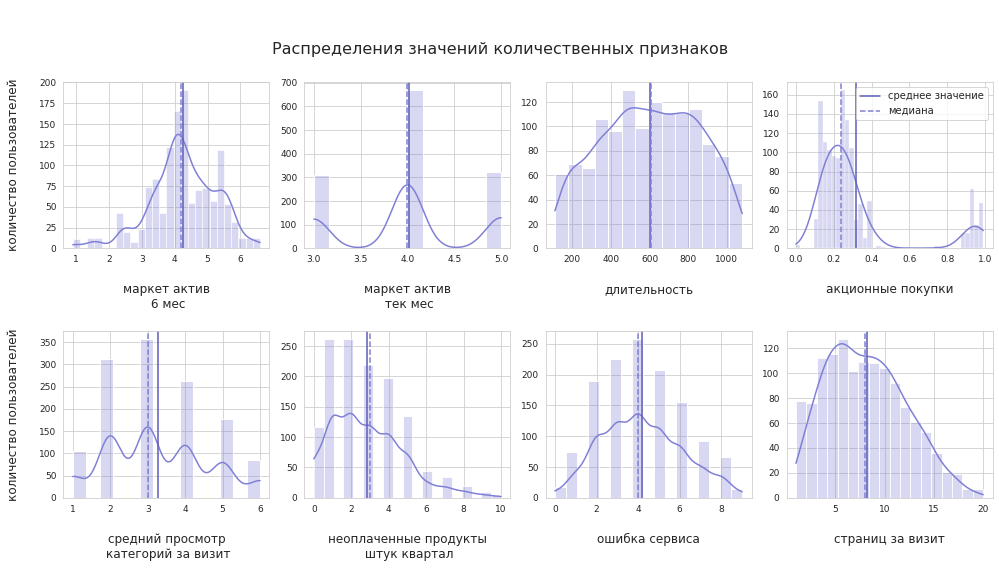

In [24]:
fig, users_f, out_f = numerical(file)



**`маркет актив 6 мес`**

По гистограмме видно, что маркетинговая коммуникация с клиентами за последние шесть месяцев менялась - компания в поисках лучшей стратегии. Распределение **ближе к нормальному**, **среднее и медиана почти равны** и составляют 4.2, однако присутствует несколько очень малых значений (их доля менее 3%), которые стоит удалить.

**`маркет актив тек мес`**

Данное распределение **симметричное мультимодальное** с тремя выраженными пиками значений, которые принимают только три значения: 3, 4, 5. **Среднее и медиана равны 4**, а доля выбросов составляет более 48% процентов. Это указывает на три категории маркетинговых стратегий для разных пользователей в текущем месяце. Такой признак можно считать ранговым.

**`длительность`**

Большинство клентов используют сервис от 400 до 800 дней. Распределение **нормальное** с небольшим плато в центре, **среднее и медиана совпадают** и немного превышают 600, выбросы отсутствуют.

**`акционные покупки`**

Распределение **мультимодальное** с большим пиком и маленьким, который считается выбросом, однако эти аномалиии связаны с определенной категорией пользователей, которые любят пользоваться акциями, поэтому их стоит оставить. Из-за их наличия **среднее больше медианы**.

**`средний просмотр категорий за визит`**

Хоть это не дискретный признак, у него **скошенное в право нормальное распределение**, из-за чего **медиана меньше среднего**. Выбросы отсутствуют. Существуют пользователи, которые в среднем просматривают как всего одну категорию за визит, так и все существующие на сайте. Большинство просматривают около половины категорий.

**`неоплаченные продукты штук квартал`**

Данное распределение также **скошено вправо**, однако **медиана немного больше среднего**, а доля выбросов составляет 1%. В основном в корзине пользователей менее шести неоплаченных товаров.

**`ошибка сервиса`**

Распределение нормальное, **медиана немного меньше среднего**, выбросы отсутствуют. Чаще ошибок на сайте не более четырех, однако пользователь может столкнуться с девятью ошибками.

**`страниц за визит`**

Это **скошенное в право нормальное распределение**, **среднее и медиана равны 8**, выбросы отсутствуют. Пользователи посещают не более 20 страниц за визит - в основном от 5 до 10.

**Таблица `money`**

В таблице `money` один количественный признак — `выручка` — сумма выручки за период.



Сводная статистика


,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000




Доля выбросов количественных признаков


,Признак,Доля выбросов,Менее,Более
0,выручка,4.49%,67,108


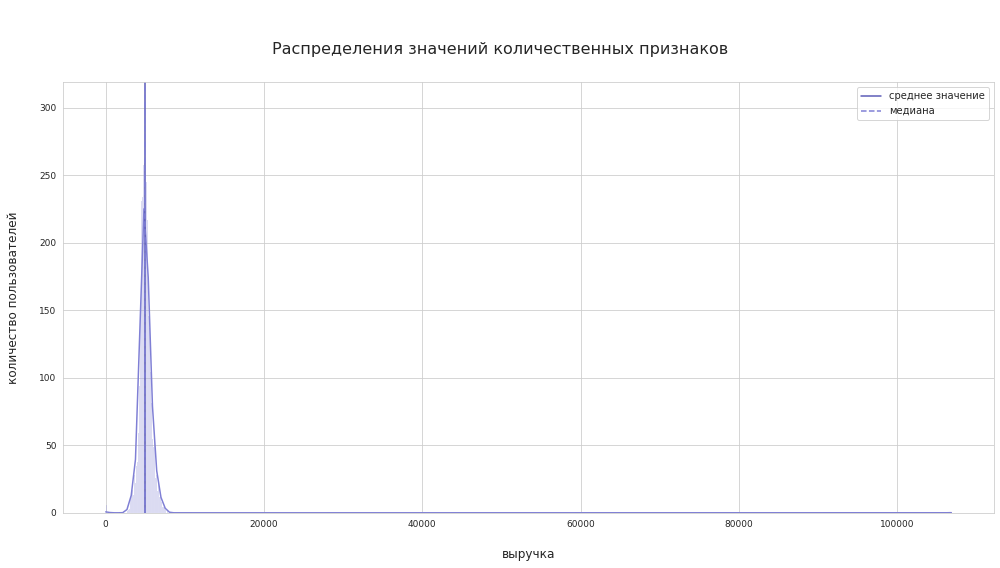

In [25]:
fig, users_m, out_m = numerical(money)

Данный признак распределен **нормально**, **среднее немного меньше медианы**, присутствует 4% выбросов. Обычно выручка составляет от 4500 до 5400 за один период.

По графику видно, что в данных присутствуют аномально высокие показатели выручки, посмотрим, сколько таких аномальных пользователей.

In [26]:
money[money['выручка'] > 10000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Такой пользователь только один ( `id` = 215380 )

**Таблица `time`**

В данной таблице - `минут` — значение времени, проведённого на сайте, в минутах.



Сводная статистика


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000




Доля выбросов количественных признаков


,Признак,Доля выбросов,Менее,Более
0,минут,0.00%,0,0


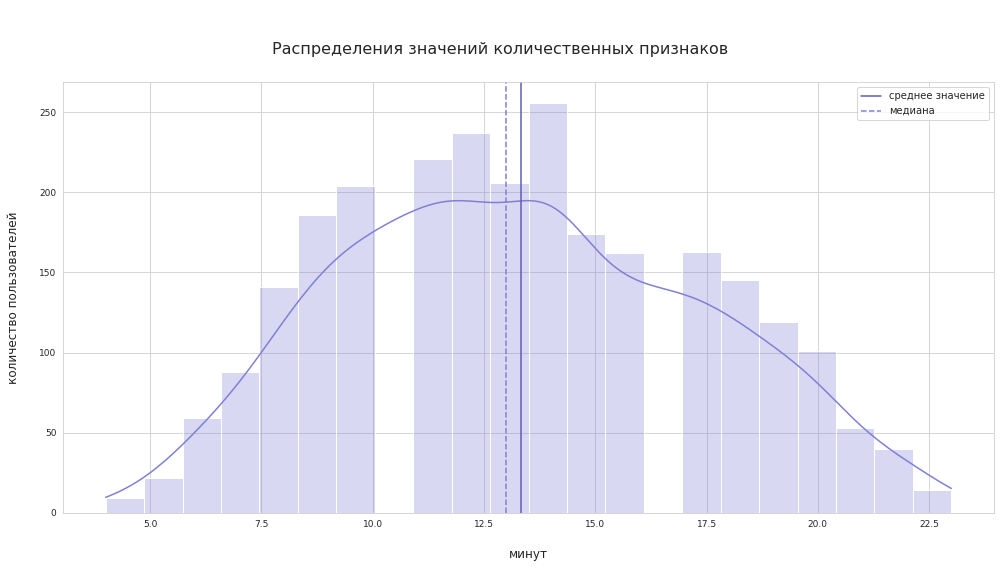

In [27]:
fig, users_t, out_t = numerical(time)

Распределение **нормальное**, **среднее немного больше медианы**, выбросы отсутствуют. За один период пользователи проводят на сайте от 4 до 23 минут.

**Таблица `mean_money`**

Здесь едиинственный количественный признак - `прибыль` — значение прибыли.



Сводная статистика


,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000




Доля выбросов количественных признаков


,Признак,Доля выбросов,Менее,Более
0,прибыль,0.92%,5,7


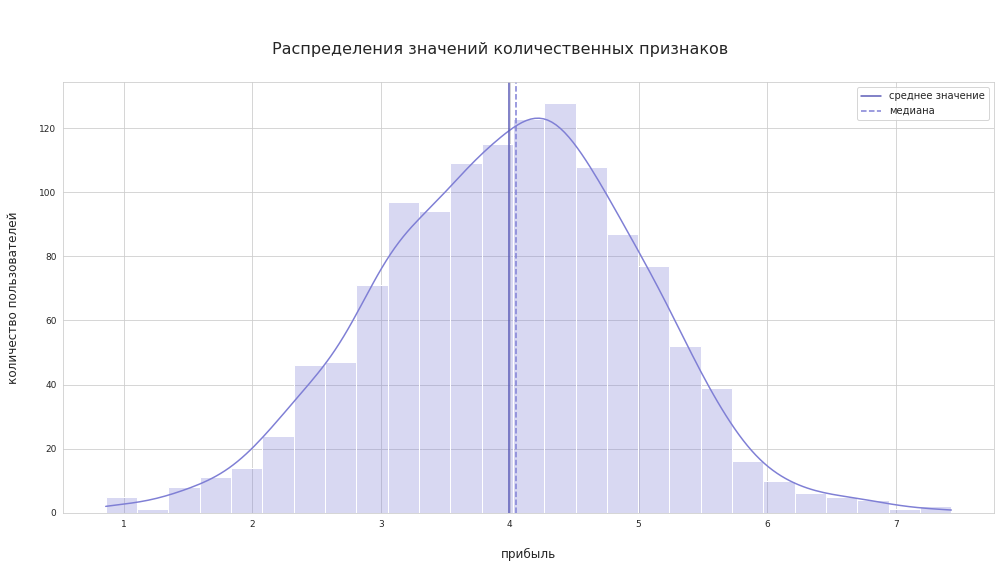

In [28]:
fig, users_mm, out_mm = numerical(mean_money)

Данное распределение **нормальное**, **среднее и медиана примерно равны 4**, присутствует 1% выбросов. Основное значение прибыли от продаж каждому покупателю лежит в интервале от 3 до 5.

#### Удаление выбросов

Ранее были получены списки пользователей, поведение которых можно считать выбросами. Удалим их и проверим, насколько сократился объем данных.

Зафиксируем текущее количество пользователей.

In [29]:
# контроль объема
count = {}
count['b'] = file['id'].count()

# пользователь с аномальной выручкой
file = file[file['id'] != 215380]

# активные пользователи
file = file[file['id'].isin(act[act['выручка'] >= 3].index)]

us = file['id'].values
money = money[money['id'].isin(us)]
time = time[time['id'].isin(us)]

count['a'] = file['id'].count()

print('\033[1mКонтроль обема\033[0m')
print(f'\n\033[1mБыло\033[0m - {count["b"]}')
print(f'\033[1mСтало\033[0m - {count["a"]}')
print(f'\n\033[1mДоля\033[0m - {(count["b"]-count["a"])/count["b"]*100:.4f}%')

Контроль обема

Было - 1300
Стало - 1296

Доля - 0.3077%


Объем выборки сократился на 0,31%, что является приемлемым значением.

### Категориальные признаки

Ознакомимся с распределением категориальных признаков.

**Таблица `file`**

В таблице `file` четыре категориальных признака:

- `покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `популярная категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.


,id,доля
покупательская активность,,
Прежний уровень,802,61.88%
Снизилась,494,38.12%
Сумма,1296,100.00%


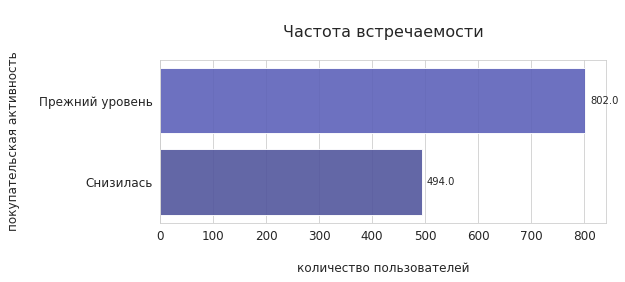

,id,доля
тип сервиса,,
стандарт,922,71.14%
премиум,374,28.86%
Сумма,1296,100.00%


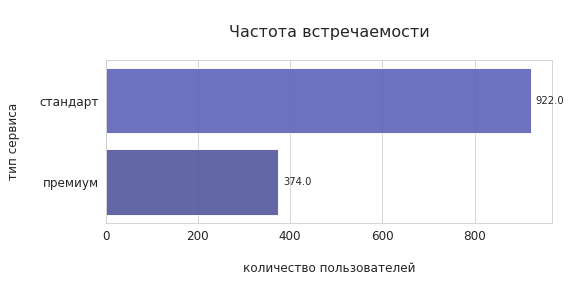

,id,доля
разрешить сообщать,,
да,959,74.00%
нет,337,26.00%
Сумма,1296,100.00%


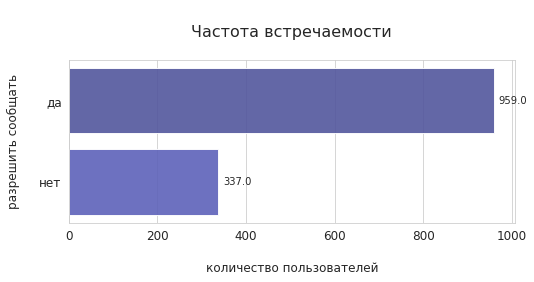

,id,доля
популярная категория,,
Товары для детей,329,25.39%
Домашний текстиль,250,19.29%
Косметика и аксесуары,223,17.21%
Техника для красоты и здоровья,182,14.04%
Мелкая бытовая техника и электроника,174,13.43%
Кухонная посуда,138,10.65%
Сумма,1296,100.00%


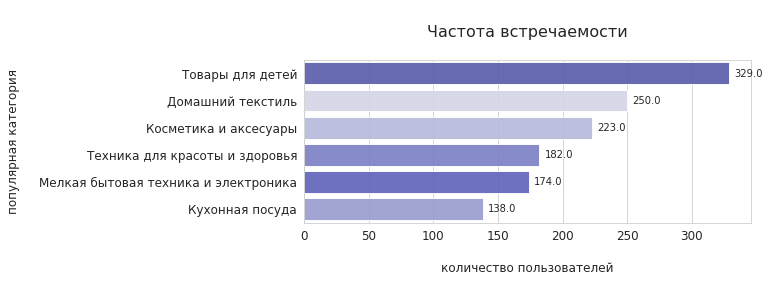

In [30]:
fig = categorical(data=file)

**Данные несбалансированные**, только у **35%** пользователей **снизилась активность** за исследуемый период.

Более **71%** пользователей используют **стандартный тип** сервиса.

Большинство (**74%**) клиентов **хотят получать** дополнительные **предложения** о товаре.

**Товары для детей** - **самая популярная категория** тотваров, а **наименее популярная** - **кухонная посуда**. Судя по остальным популярным категориям, целевая аудитория данного сервиса - женщины с детьми, предположительно имеющие опыт с аналогичными сервисами.

**Таблица `money`**

В таблице `money` одиин категориальный признак - `период` — название периода, во время которого зафиксирована выручка.

,id,доля
период,,
предыдущий_месяц,1296,33.33%
препредыдущий_месяц,1296,33.33%
текущий_месяц,1296,33.33%
Сумма,3888,100.00%


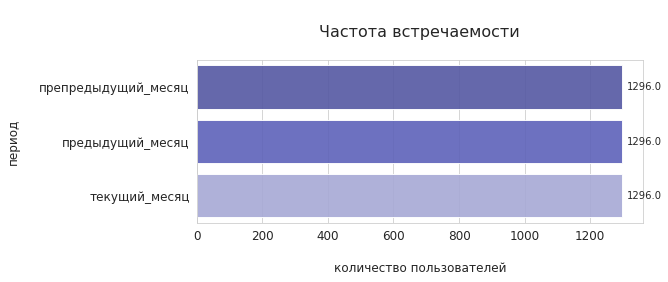

In [31]:
fig = categorical(data=money)

У каждого пользователя есть данные за каждый период использования.

**Таблица `time`**

В таблице `time` также одиин категориальный признак - `период` — название периода, во время которого зафиксировано общее время.

,id,доля
период,,
предыдущий_месяц,1296,50.00%
текущий_месяц,1296,50.00%
Сумма,2592,100.00%


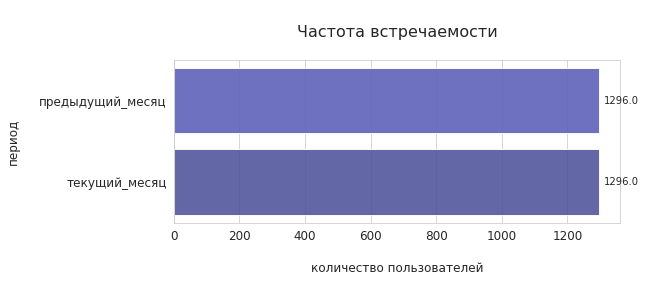

In [32]:
fig = categorical(data=time)

Здесь аналогично есть данные за каждый период.

**Таблица `mean_money`**

В данной таблице нет категориальных признаков.

### Вывод

В процессе анализа признаков было замечено:
- **Нормальное распределение** у столбцов: `маркет актив 6 мес`, `длительность`, `средний просмотр категорий за визит`, `неоплаченные продукты штук квартал`, `ошибка сервиса`, `страниц за визит`, `минут`, `прибыль`
- У столбцов `маркет актив тек мес` и `акционные покупки` **мльтимодальное распределение**
- Сервис экспериментирует с **разными маркетинговыми стратегииями**
- Есть **категория пользователей** в основном приобретающих **только акционные товары**
- Целевая аудитория сервиса - **женщины с детьми**
- **`товары для детей`** - самая популярная категория товаров
- **Более** чем у **350** пользователей **снизилась покупательская активность**
- Присутствует **дисбаланс классов**

<a id='step4'></a>
## Объединение таблиц

### Подготовка

В таблицах `money` и `time` есть информация о каждом пользователе из таблицы `file` за три и два периода соответственно. Преобразуем таблицы `money` и `time`, чтобы каждый период хранился в отдельном столбце.

In [33]:
# создание сводной таблицы 
money = (pd.pivot_table(money, index='id', columns='период', values='выручка').reset_index())

# переименование столбцов
money.columns=['id', 'пре выр', 'препре выр', 'тек выр']

money.head()

,id,пре выр,препре выр,тек выр
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [34]:
# создание сводной таблицы 
time = pd.pivot_table(time, index='id', columns='период', values='минут').reset_index()

# переименование столбцов
time.columns=['id', 'пре мин', 'тек мин']

time.head()

,id,пре мин,тек мин
0,215349,12,10
1,215350,8,13
2,215351,11,13
3,215352,8,11
4,215353,10,10


Проверим наличие данных о каждом пользователе в таблицах.

In [35]:
# проверим количество
print('file - ', file['id'].count())
print('money - ', money['id'].count())
print('time - ', time['id'].count())

# уникальные значения
if set(file['id'].values) == set(money['id'].values) == set(time['id'].values):
    print('\nСписки уникальных значений совпадают')

file -  1296
money -  1296
time -  1296

Списки уникальных значений совпадают


### Объединение

Теперь можно объединить все таблицы

In [36]:
data = pd.merge(file, money, on=['id'], how='left')
data = pd.merge(data, time, on=['id'], how='left')

# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская активность            1296 non-null   object 
 2   тип сервиса                          1296 non-null   object 
 3   разрешить сообщать                   1296 non-null   object 
 4   маркет актив 6 мес                   1296 non-null   float64
 5   маркет актив тек мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные покупки                    1296 non-null   float64
 8   популярная категория                 1296 non-null   object 
 9   средний просмотр категорий за визит  1296 non-null   int64  
 10  неоплаченные продукты штук квартал   1296 non-null   int64  
 11  ошибка сервиса                

In [37]:
data.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,пре выр,препре выр,тек выр,пре мин,тек мин
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


### Вывод

Таблицы `file`, `money`, `time` были успешно объединены. Данные о каждом периоде хранятся в отдельных столбцах, все данные о пользователях сохранены.

<a id='step5'></a>
## Корреляционный анализ

Так как ранее было выявлено, что не все признаки распределены нормально, а также в данных присутствуют категориальные признаки, для построения матрицы корреляции будем использовать корреляцию Phik.

In [38]:
# функция построения матрицы корреляции
def corr(data):
    fig, ax = plt.subplots(figsize=(14, 11))
    
    sns.heatmap(data, annot=True, center=0, cmap= 'PuOr')
    
    chart_labels(title='Матрица корреляци', 
                 xlabel='', ylabel='', ax=ax)
    
    plt.show()
    
# матрица корреляции для всех признаков
corr(data.loc[:, 'покупательская активность':].phik_matrix())

interval columns not set, guessing: ['маркет актив 6 мес', 'маркет актив тек мес', 'длительность', 'акционные покупки', 'средний просмотр категорий за визит', 'неоплаченные продукты штук квартал', 'ошибка сервиса', 'страниц за визит', 'пре выр', 'препре выр', 'тек выр', 'пре мин', 'тек мин']


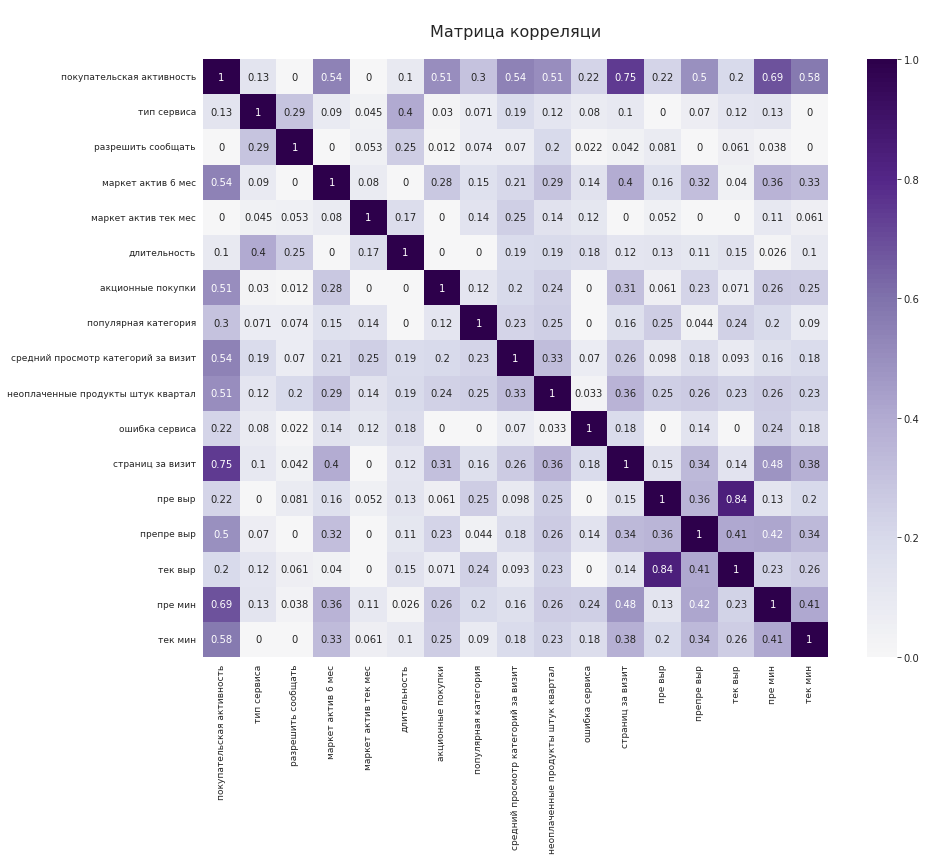

In [39]:
# матрица корреляции для всех признаков
corr(data.loc[:, 'покупательская активность':].phik_matrix())

Целевой признак **`покупательская активность` сильнее всего коррелирует** с признаками `страниц за визит` и `пре мин` - время, проведенное на сервисе влияет на вероятность покупки. 

У него также **хорошая корреляция** с признаками `тек мин`, `средний просмотр категорий за визит`, `акционные покупки`, `препре выр` и `маркет актив 6 мес`. 

А также целевой признак абсолютно **не зависит** от признаков `разрещить сообщать` и `маркет актив тек мес` Маркетинговые коммуникации будут влиять на активность пользователя в последующих периодах. 

Наблюдается мультиколлинеарность между признаками `тек выр` и `пре выр`. Текущие показатели выручки зависят от предыдущего периода, однако это значение некритично - признаки можно оставить в таком виде.

### Вывод

Был проведен корреляционный анализ количественных и категориальных признаков, в результате которого выявлены следующие закономерности:

Целевой признак `покупательская активность`:
- сильнее всего коррелирует с признаками `страниц за визит` и `пре мин`
- полносттью независит от признаков `разрешить сообщать` и `маркет актив тек мес`

Между нецелевыми признаками `тек выр` и `пре выр` есть сильная связь.

<a id='step6'></a>
## Создание модели

### Разделение данных на обучающую и тестовую выборки

**Цклквой признак `покупательская активность`** — рассчитанный класс покупательской активности: «снизилась» или «прежний уровень».

Закодируем целевой признак.

In [40]:
def encoding(x):
    return 1 if x == 'Снизилась' else 0

data['target'] = data['покупательская активность'].apply(encoding)

Ранее было выявлено, что в данных присутствует дисбаланс классов, однако это отражает реальное распределение данных, поэтому стоит об этом помнить, но не устранять. 

Разделим данные на обучающую и тестовую выборки в соотношении 3:1 соответственно с учетом несбалансированности данных.

In [41]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

data = data.set_index('id')

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['покупательская активность', 'target'], axis=1),
    data['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['target'])

print(f'Размерность обучающей и тестовой выборок: {X_train.shape}, {X_test.shape}\n')

X_train.info()

Размерность обучающей и тестовой выборок: (972, 16), (324, 16)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 215858 to 216030
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   тип сервиса                          972 non-null    object 
 1   разрешить сообщать                   972 non-null    object 
 2   маркет актив 6 мес                   972 non-null    float64
 3   маркет актив тек мес                 972 non-null    int64  
 4   длительность                         972 non-null    int64  
 5   акционные покупки                    972 non-null    float64
 6   популярная категория                 972 non-null    object 
 7   средний просмотр категорий за визит  972 non-null    int64  
 8   неоплаченные продукты штук квартал   972 non-null    int64  
 9   ошибка сервиса                       972 non-null    int64  
 10  страниц за визит          

### Категориальные и количественные признаки

Всего в таблице **3 категориальных признака**: `популярная категория`, `тип сервиса`, `разрешить сообщать`. Первый из них можно закодировать с помощью OneHotEncoder, а остальные - с помощью OrdinalEncoder.

Также столбцы `маркет актив тек мес`, `средний просмотр категорий за визит`, `неоплаченные продукты штук квартал`, `ошибка сервиса` являются **ранговыми признаками**, так как они имеют ограниченный диапазон значений и порядок. К ним можно относиться и как к категориальным, и как к количественным признакам. Проверим, какие уникальные значения в этих столбцах.

In [42]:
range_columns = ['маркет актив тек мес', 'средний просмотр категорий за визит', 
                 'неоплаченные продукты штук квартал', 'ошибка сервиса']

unique(X_train, range_columns)


Уникальные значения в категориальных столбцах:

маркет актив тек мес: [4 5 3]
средний просмотр категорий за визит: [2 4 5 3 1 6]
неоплаченные продукты штук квартал: [ 4  5  1  7  2  6  3  0 10  9  8]
ошибка сервиса: [7 2 3 5 8 4 6 1 0 9]


Остальные **9 признаков** являются **количественными**: `маркет актив 6 мес`, `длительность`, `акционные покупки`, `страниц за визит`, `пре выр`, `препре выр`, `тек выр`, `пре мин`, `тек мин`. Их можно кодировать с помощью StandardScaler() или MinMaxScaler().

In [43]:
# списки с названиями признаков
ohe_columns = ['популярная категория']
ord_columns = ['тип сервиса', 'разрешить сообщать']
num_columns = ['маркет актив 6 мес', 'длительность', 'акционные покупки', 
               'страниц за визит', 'пре выр', 'препре выр', 'тек выр', 'пре мин', 'тек мин']

### Пайплайны

#### Пайплайны для подготовки данных

Создадим пайплайны для кодирования количественных и категориальных признаков.

Перед OneHotEncoder заменим пропуски наиболее частым значением. Аналогично поступим перед Ordinal-кодированием, а также произведем замену после кодирования, если были замечены неизвестные значения. Отдельно реализуем пайплайн для кодирования ранговых признаков. Также произведем кодирование количественных признаков и объединим все опрерации в один пайплайн.

In [44]:
# заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# заполнение пропусков и Ordinal-кодирование
rng_pipe = Pipeline(
    [('simpleImputer_before_ord_rng', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord_rng',  OrdinalEncoder(
                categories=[
                    [i for i in range(3, 6)], 
                    [i for i in range(1, 7)],
                    [i for i in range(0, 9)],
                    [i for i in range(0, 10)]
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord_rng', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
     ('rng', rng_pipe, range_columns)
    ], 
    remainder='passthrough'
)

#### Общий пайплайн

In [45]:
# подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#### Подбор гиперпараметров с помощью RandomizedSearchCV

Для перебора гиперпараметров будет использован **RandomizedSearchCV** с 50 итерациями, который ускорит перебор гиперпараметров.

При кросс-валидации данные будут разделены на пять блоков.

Для решения задачи бинарной классификации будут рассмотрены следующие модели: **метод k-ближайших соседей, дерево решений, логистическая регрессия и метод опорных векторов**.

Для решения поставленной задачи важно чтобы были найдены все клиенты класса 1, у которых покупательская активность снизилась, однако стоит также учитывать объекты другого класса. С учетом дисбаланса классов стоит выбирать лучшую модель по метрике **F1** и среди лучших пяти моделей взять с максимальным показателем метрики **recall**.

In [46]:
# способ отбора лучшей модели
def refit_strategy(cv_results):

    result = pd.DataFrame(cv_results)
    
    cols = ['rank_test_recall', 'rank_test_f1']

    return result[cols].sort_values('rank_test_f1').head()['rank_test_recall'].idxmin()

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier()],
        'models__random_state': range(0, 100),
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 17),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__rng': [StandardScaler(), MinMaxScaler(), rng_pipe, 'passthrough'] 
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 14),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__rng': [StandardScaler(), MinMaxScaler(), rng_pipe, 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression( 
            solver='liblinear'
        )],
        'models__random_state': range(0, 100),
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__rng': [StandardScaler(), MinMaxScaler(), rng_pipe, 'passthrough']
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            probability=True
        )],
        'models__kernel': ['sigmoid', 'rbf'],
        'models__random_state': range(0, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__rng': [StandardScaler(), MinMaxScaler(), rng_pipe, 'passthrough']
    }
]

# cписок метрик
scoring = ['accuracy', 'precision', 'recall', 'f1']

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scoring,
    refit=refit_strategy,
    n_jobs=-1,
    n_iter=50,
    random_state=RANDOM_STATE
)

#### Обучение и оценка качества модели

Обучим модель и проверим ее качество на тренировочной выборке.

In [47]:
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['популярная '
                                                                                'категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                Sim...
                                                                               ('ord_rng',
                                                                                OrdinalEncoder(categories=[[3,
                                                                                                            4,
                                                                                                            5],
                                                                                                           [1,
                                                                                                            2,
                                                                                                            3,
                                                                                                            4,
                                                                                                            5,
                                                                                                            6],
                                                                                                           [0,
                                                                                                            1,
                                                                                                            2,
                                                                                                            3,
                                                                                                            4,
                                                                                                            5,
                                                                                                            6,
                                                                                                            7,
                                                                                                            8],
                                                                                                           [0,
                                                                                                            1,
                                                                                                            2,
                                                                                                            3,
                                                                               

In [48]:
cols = ['param_models',
        'rank_test_recall', 'mean_test_recall', 'rank_test_f1', 'mean_test_f1',
        'rank_test_accuracy', 'mean_test_accuracy', 'rank_test_precision', 'mean_test_precision',
        'param_preprocessor__rng', 'param_preprocessor__num'
       ]

result = (pd.DataFrame(randomized_search.cv_results_)[cols]
          .sort_values('rank_test_f1').head()
          .sort_values(by='rank_test_recall', ascending=True))

print ('Средний показатель F1-меры при кросс-валидации лучшей модели на обучающей выборке:', 
       result['mean_test_f1'].values[0])


Средний показатель F1-меры при кросс-валидации лучшей модели на обучающей выборке: 0.801212705508016


Посмотрим лучшие пять моделей.

In [49]:
result

,param_models,rank_test_recall,mean_test_recall,rank_test_f1,mean_test_f1,rank_test_accuracy,mean_test_accuracy,rank_test_precision,mean_test_precision,param_preprocessor__rng,param_preprocessor__num
12,LogisticRegression(solver='liblinear'),1,0.757369,3,0.801213,4,0.856981,20,0.852936,passthrough,StandardScaler()
8,LogisticRegression(solver='liblinear'),2,0.754667,4,0.799653,5,0.855945,19,0.853015,"(SimpleImputer(strategy='most_frequent'), Ordi...",StandardScaler()
36,LogisticRegression(solver='liblinear'),3,0.754667,2,0.809161,2,0.864177,11,0.875579,MinMaxScaler(),passthrough
22,SVC(probability=True),4,0.749261,1,0.813609,1,0.869315,4,0.892285,passthrough,StandardScaler()
23,DecisionTreeClassifier(),26,0.703387,5,0.790054,3,0.858002,2,0.902597,MinMaxScaler(),passthrough


У лучшей модели наивысшие показатели метрик F1 (0.80) и recall (0.76).

Посмотрим структуру данной модели.

In [50]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')...
                                                 ('num', StandardScaler(),
                                                  ['маркет актив 6 мес',
                                                   'длительность',
                                                   'акционные покупки',
                                                   'страниц за визит',
                                                   'пре выр', 'препре выр',
                                                   'тек выр', 'пре мин',
                                                   'тек мин']),
                                                 ('rng', 'passthrough',
                                                  ['маркет актив тек мес',
                                                   'средний просмотр категорий '
                                                   'за визит',
                                                   'неоплаченные продукты штук '
                                                   'квартал',
                                                   'ошибка сервиса'])])),
                ('models',
                 LogisticRegression(C=6, penalty='l1', random_state=81,
                                    solver='liblinear'))])

Характеристики лучшей модели:

- Логистическая регрессия (C=6, penalty='l1', random_state=81, solver='liblinear')
- стандартизация количественных признаков
- кодирование ранговых признаков отсутствует

Проверим качество модели на тестовых данных.


Оценка качества модели:
recall:   0.813008
f1 score: 0.865801


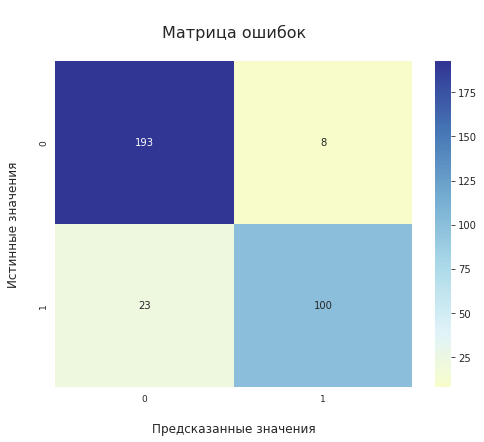

In [51]:
# метрики
def metrics(y_test, y_pred):
    
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('\n\033[1mОценка качества модели:\033[0m')
    print(f'recall:   {recall:.6f}')
    print(f'f1 score: {f1:.6f}')
    
    # матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # график
    sns.heatmap(cm, annot=True, fmt='d', center=0, cmap= 'RdYlBu', ax=ax)
    
    # подписи
    chart_labels(title='Матрица ошибок', 
                 xlabel='Предсказанные значения', ylabel='Истинные значения', ax=ax)
    
    plt.show()
    
metrics(y_test, randomized_search.predict(X_test))

Качество модели немного повысилось на тестовом наборе данных. Модель хуже справляется с классификацией объектов минорного класса.

### Вывод

- Закодирован целевой признак
- Данные разделены на обучающую и тестовую выборки
- Создан пайплайн для кодирования признаков и обучения модели
- Путем случайного поиска была отобрана лучщая модель - логистическая регрессия
- Метрики лучшей модели на тестовой выборке: recall - 0.81, F1-мера - 0.87


<a id='step7'></a>
## Анализ важности признаков

Сначала необходимо подготовить тестовый набор данных для анализа модели.

In [52]:
preprocessor = randomized_search.best_estimator_['preprocessor']
X_test_t = preprocessor.transform(X_test)

column_names = preprocessor.get_feature_names_out()
column_names = [s.replace('__популярная категория_', '_').replace('__', '_') for s in column_names]

X_test_t = pd.DataFrame(X_test_t, columns=column_names)
X_test_t.head()

,ohe_Косметика и аксесуары,ohe_Кухонная посуда,ohe_Мелкая бытовая техника и электроника,ohe_Техника для красоты и здоровья,ohe_Товары для детей,ord_тип сервиса,ord_разрешить сообщать,num_маркет актив 6 мес,num_длительность,num_акционные покупки,num_страниц за визит,num_пре выр,num_препре выр,num_тек выр,num_пре мин,num_тек мин,rng_маркет актив тек мес,rng_средний просмотр категорий за визит,rng_неоплаченные продукты штук квартал,rng_ошибка сервиса
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.169629,-0.003856,-0.678649,0.961202,-1.405144,0.214194,-2.320463,0.624051,0.894668,4.0,6.0,1.0,4.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-2.866015,0.307182,2.517826,-0.557143,-2.013227,-0.540665,-1.271572,-0.647600,-1.024488,4.0,3.0,6.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.968558,-0.474402,-0.759573,0.455087,0.699537,-0.808993,1.304666,1.641373,-0.544699,4.0,4.0,2.0,8.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.768826,1.794585,0.130585,-0.557143,2.359246,0.453036,1.807872,-1.156261,-1.024488,3.0,4.0,3.0,5.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.228498,-1.834199,2.720134,-0.304085,0.193040,-1.145141,0.635946,0.369721,1.134563,4.0,1.0,2.0,3.0


Также создадим тестовый набор данных с предсказанными и истинными метками класса.

In [53]:
X_y_test = X_test.reset_index()
X_y_test['вероятность'] = randomized_search.predict_proba(X_test)[:, 1]
X_y_test['предсказанное'] = randomized_search.predict(X_test)
X_y_test['истинное'] = list(y_test)

X_y_test.head()

,id,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,пре выр,препре выр,тек выр,пре мин,тек мин,вероятность,предсказанное,истинное
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0.013120,0,0
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.989010,1,1
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0.100831,0,0
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,0.824882,1,1
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.493360,0,1


Посмотрим, какие признаки наиболее значимы для предсказания модели.

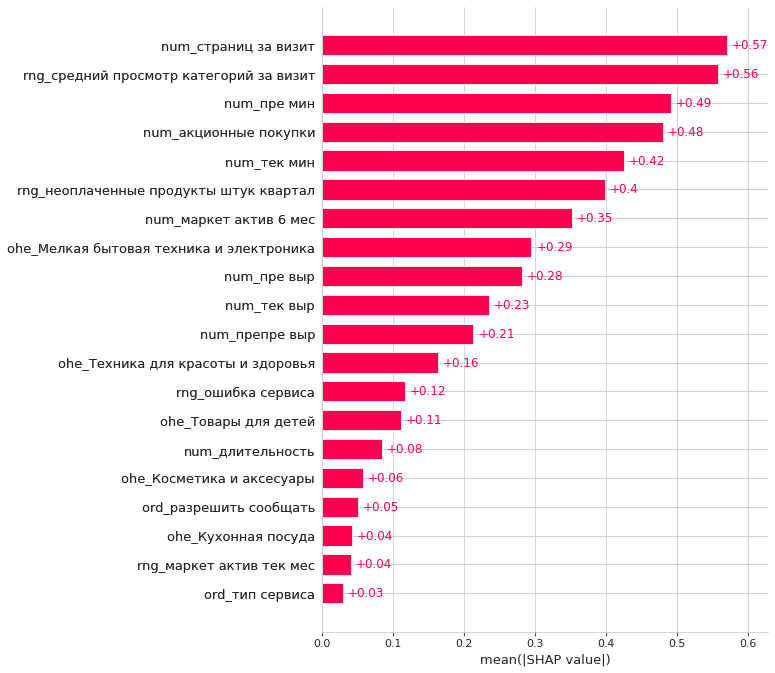

In [54]:
model = randomized_search.best_estimator_['models']

explainer = shap.LinearExplainer(model, X_test_t)
shap_values = explainer(X_test_t)
shap.plots.bar(shap_values, max_display=21)

Сильнее всего на прогнозы модели влияет среднее количество страниц, которые просмотрел покупатель за один визит, а также время, проведенное на сайте в прошлом и текущем месяцах.

На сайте возникает незначительное кольчество ошибок, которые не оказывают влияния на активность пользователей.

Посмотрим, какие значения признаков, в какою сторону склоняют предсказания модели.

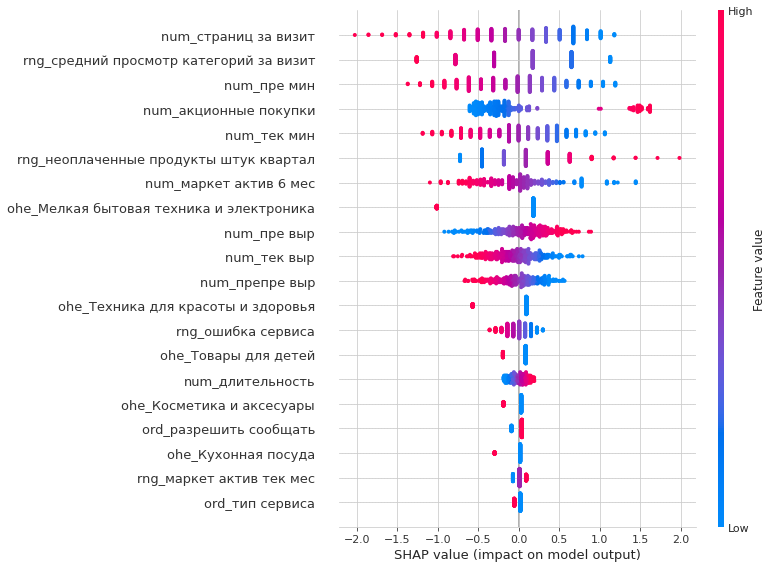

In [55]:
shap.plots.beeswarm(shap_values, max_display=21)

Вероятнее всего **активность** пользователя **снизится**, если:

- у него небольшое среднее количество просмотренных страниц (чем больше будет просмотрено товаров, тем вероятнее произойдет покупка)
- пользователь в прошлом или текущем месяце в среднем провел мало времени на сайте (со временем пользователь может просто забыть про данный сайт)
- в среднем просмотрено менее половины категорий за визит
- много неоплаченных продуктов за квартал
- низкое среднемесячное значение маркетинговых коммуникаций компании
- пользователь часто совершает акционные покупки 
- в предыдущих периодах выручка высокая (после больших трат расходы пользователей на более дешевые товары будут снижаться)
- у пользователя популярны следуюшие категории товаров: косметика и аксесуары или кухонная посуда

Мелкая бытовая техника и электроника, товары для детей, техника для красоты и здоровья вероятнее всего не снижают покупательскую активность пользователей.

Проверим несколько ошибочных прогнозов.

In [56]:
X_y_test.loc[X_y_test['предсказанное']!=X_y_test['истинное']].head()

,id,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,пре выр,препре выр,тек выр,пре мин,тек мин,вероятность,предсказанное,истинное
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.493360,0,1
24,215907,стандарт,да,6.6,3,839,0.24,Косметика и аксесуары,3,3,4,15,4830.0,4779.0,4915.8,14,11,0.088937,0,1
27,215938,стандарт,да,5.2,3,591,0.18,Техника для красоты и здоровья,2,1,4,17,5922.5,4439.0,7338.2,15,13,0.037416,0,1
32,216230,стандарт,да,3.5,4,823,0.24,Техника для красоты и здоровья,2,4,2,10,5246.0,4868.0,5703.6,18,8,0.505480,1,0
67,215746,премиум,да,4.4,4,987,0.35,Техника для красоты и здоровья,3,1,8,6,3222.0,4932.0,4169.7,10,9,0.362592,0,1


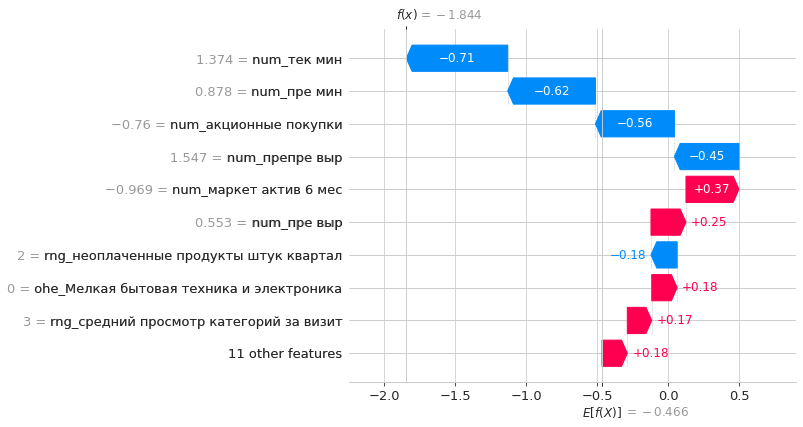

In [57]:
shap.plots.waterfall(shap_values[20])

Данный пользователь провел много времени на сайте, из-за чего модель предсказала, что активность останется на прежнем уровне.

Теперь посмотрим, почему модель ошибочно предсказала снижение активности.

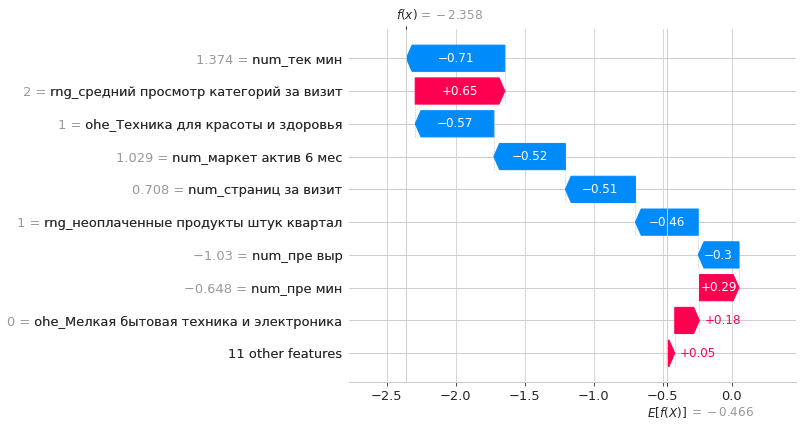

In [58]:
shap.plots.waterfall(shap_values[26])

Данный пользователь не просматривал различные категории товаров и провел мало времени на сайте, из-за чего был дан неверный прогноз.


### Вывод

В результате анализа важности признаков было выявлено, что:
- наиболее значимыми признаками для модели являются: среднее количество страниц и просмотренных категорий за визит, а также время, проведенное на сайте
- при увеличении выручки вероятность снижения активности также увеличивается
- возникающие на сайте ошибки не влияют на активность пользователей
- не все пользователи имеют одинаковый шаблон поведения, что и приводит к ошибкам модели.

<a id='step8'></a>
## Сегментация покупателей


Сначала добавим в таблицу информацию о прибыли, которую получает магазин от продаж каждому покупателю.

In [59]:
segment = X_y_test.merge(mean_money, how='left', on='id')
segment.head()

,id,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,пре выр,препре выр,тек выр,пре мин,тек мин,вероятность,предсказанное,истинное,прибыль
0,216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0.013120,0,0,4.69
1,215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.989010,1,1,2.75
2,216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0.100831,0,0,3.16
3,215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,0.824882,1,1,3.74
4,215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.493360,0,1,4.40


Товары, приобретенные по акции, могут приносить высокую прибыль, однако после таких покупок может начать снижаться покупательская активность.

Рассмотрим распределение значений прибыли и вероятности снижения покупательской активности с учетом доли акционных покупок.

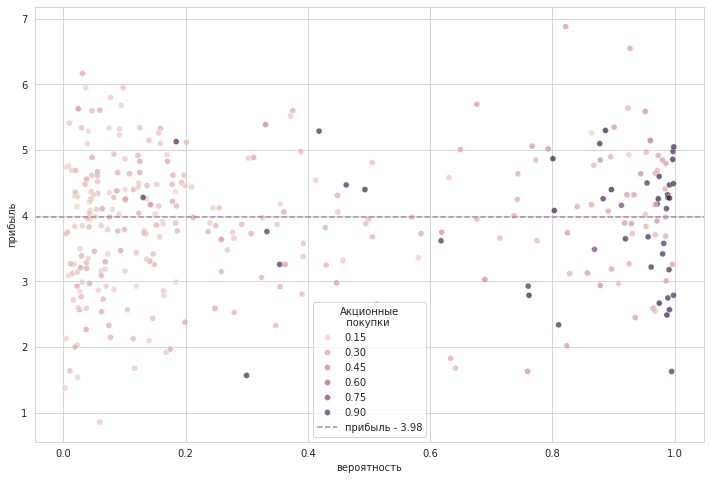

In [60]:
# создание графика
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(data=segment, x='вероятность', y='прибыль', hue='акционные покупки', alpha=0.7)
# медиана
ax.axhline(y=segment['прибыль'].median(), color='#A989AE', 
           linestyle='--', label=f'прибыль - {segment["прибыль"].median()}')

ax.legend(title='Акционные\n  покупки')

Высокую прибыль приносят пользователи независимо от вероятности снижения их покупательской активности, однако у пользователей, которые в основном приобретают товары по акции, с наибольшей вероятностью снизится активность.

Рассмотрим пользователей, которые предпочитают приобретать такие товары со скидкой, которые приносят высокую прибыль, и у которых существует риск снижения покупательской активности.

In [61]:
segment = segment[(segment['прибыль']>3.98)&(segment['вероятность']>0.6)&(segment['акционные покупки']>0.75)]
segment.head()

,id,тип сервиса,разрешить сообщать,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,популярная категория,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,пре выр,препре выр,тек выр,пре мин,тек мин,вероятность,предсказанное,истинное,прибыль
12,215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,0.971565,1,1,4.18
18,215452,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,4045.0,4963.0,4206.2,11,10,0.954933,1,1,4.50
55,215604,стандарт,нет,3.1,5,458,0.99,Косметика и аксесуары,1,5,3,4,4449.0,4308.0,4459.4,8,10,0.997066,1,1,4.86
60,215628,стандарт,да,4.0,4,618,0.93,Товары для детей,3,5,2,2,3783.0,4566.0,3848.0,9,10,0.986744,1,1,4.11
62,215565,стандарт,нет,2.4,4,522,0.99,Кухонная посуда,2,5,4,4,4657.0,4492.0,5104.2,11,12,0.988630,1,1,4.32


**Сравнение сегмента**

Сравним данный сегмент с остальными пользователями.

In [62]:
segment.describe()

,id,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,пре выр,препре выр,тек выр,пре мин,тек мин,вероятность,предсказанное,истинное,прибыль
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0,19.000000
mean,215563.736842,3.178947,4.000000,558.052632,0.953158,2.842105,3.894737,3.842105,4.052632,5217.921053,4697.263158,5503.921053,9.894737,10.105263,0.945394,1.0,1.0,4.546316
std,153.232156,1.109344,0.666667,223.833141,0.033007,0.958190,2.354540,1.833732,1.470967,677.475097,178.508276,747.782466,2.766762,2.157538,0.066042,0.0,0.0,0.369643
min,215351.000000,0.900000,3.000000,186.000000,0.890000,1.000000,0.000000,1.000000,2.000000,3783.000000,4308.000000,3848.000000,5.000000,5.000000,0.801059,1.0,1.0,4.080000
25%,215418.500000,2.400000,4.000000,465.000000,0.930000,2.000000,2.000000,3.000000,3.500000,4801.750000,4581.000000,5132.750000,8.000000,9.000000,0.891808,1.0,1.0,4.265000
50%,215577.000000,3.200000,4.000000,550.000000,0.940000,3.000000,4.000000,3.000000,4.000000,5253.500000,4715.000000,5663.500000,9.000000,10.000000,0.974812,1.0,1.0,4.470000
75%,215669.000000,3.950000,4.000000,714.500000,0.990000,3.000000,5.000000,4.500000,4.500000,5735.500000,4783.500000,6113.150000,11.000000,11.000000,0.991684,1.0,1.0,4.865000
max,215832.000000,5.600000,5.000000,954.000000,0.990000,5.000000,9.000000,8.000000,7.000000,6158.000000,4990.000000,6610.400000,17.000000,14.000000,0.998658,1.0,1.0,5.300000


In [63]:
X_y_test.describe()

,id,маркет актив 6 мес,маркет актив тек мес,длительность,акционные покупки,средний просмотр категорий за визит,неоплаченные продукты штук квартал,ошибка сервиса,страниц за визит,пре выр,препре выр,тек выр,пре мин,тек мин,вероятность,предсказанное,истинное
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,216003.197531,4.216049,3.962963,590.969136,0.327099,3.330247,2.734568,4.157407,8.145062,4924.632716,4826.731481,5234.353704,13.243827,13.030864,0.385945,0.333333,0.379630
std,388.857258,1.048302,0.662006,243.995011,0.254989,1.380608,1.810849,1.986777,4.057704,705.928391,315.802313,815.698162,3.946130,4.373326,0.366821,0.472134,0.486045
min,215349.000000,0.900000,3.000000,129.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2960.000000,4138.000000,2952.200000,5.000000,4.000000,0.002588,0.000000,0.000000
25%,215653.500000,3.800000,4.000000,407.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4481.125000,4595.000000,4733.975000,10.000000,10.000000,0.071650,0.000000,0.000000
50%,216024.500000,4.200000,4.000000,594.500000,0.240000,3.000000,3.000000,4.000000,8.000000,4997.250000,4794.500000,5213.250000,13.000000,13.000000,0.189796,0.000000,0.000000
75%,216342.500000,4.900000,4.000000,786.000000,0.310000,4.000000,4.000000,6.000000,11.000000,5418.375000,5024.250000,5775.775000,16.000000,16.000000,0.801605,1.000000,1.000000
max,216646.000000,6.600000,5.000000,1061.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6658.500000,5624.000000,7370.600000,22.000000,23.000000,0.998658,1.000000,1.000000


Данные пользователи:

- достаточно давно зарегистрированы на сайте
- посещают в среднем менее 4 страниц за визит
- проводят на сайте около 10 минут
- сумма выручки немного ниже относительно остальных пользователей
- просматривают меньше категорий за визит


,id,доля
тип сервиса,,
стандарт,15,78.95%
премиум,4,21.05%
Сумма,19,100.00%


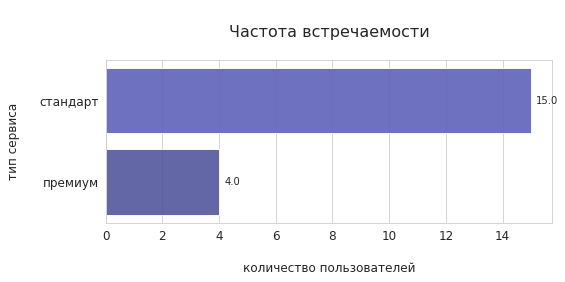

,id,доля
разрешить сообщать,,
да,14,73.68%
нет,5,26.32%
Сумма,19,100.00%


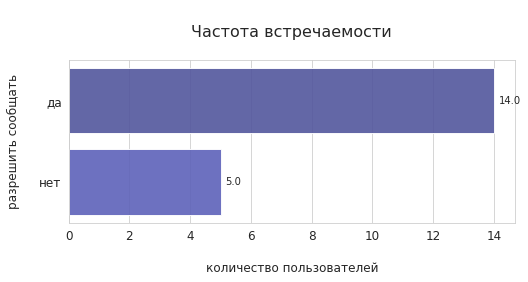

,id,доля
популярная категория,,
Товары для детей,8,42.11%
Домашний текстиль,5,26.32%
Косметика и аксесуары,2,10.53%
Кухонная посуда,2,10.53%
Мелкая бытовая техника и электроника,1,5.26%
Техника для красоты и здоровья,1,5.26%
Сумма,19,100.00%


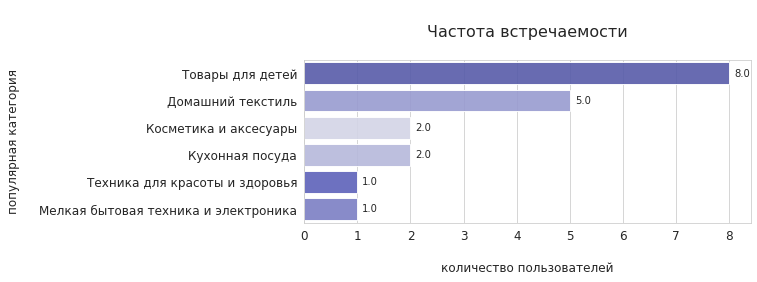

In [64]:
fig = categorical(data=segment)

Как и основная группа пользователей:
- в основном не используют платную подписку
- предпочитают получать дополнительные предложения о товаре
- наиболее популярные категории: товары для детей, домашний текстиль, косметика и аксесуары

Данная группа пользователей отличается тем, что они проводят не много времени на сайте, скорее всего целенаправленно ищут акционные товары. Наличие расширенного ассортимента товаров по скидке в популярных категориях может повысить их покупательскую активность 

### Вывод

Был проанализирован сегмент пользователей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Покупатели, приобретающие товары по акциям, обычно выбирают те категории товаров, которые не требуют регулярной покупки. Чтобы повысить покупательскую активность такого сегмента пользователей, можно чаще обновлять ассортимент акционных товаров в популярных категориях. Также можно создать отдельную страницу для таких товаров, чтобы их было легче найти.

<a id='step9'></a>
## Общий вывод

### Задача

В интернет-магазине «В один клик» начала снижаться активность покупателей, поэтому необходимо удерживать активность постоянных клиентов с помощью персонализированных предложений.

### Исходные данные

Было загружено четыре файла с исходными данными: 
- `market_file.csv` - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `market_money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `market_time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение 
- `периода.money.csv` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца.

В процессе предобработки данных было выявлено, что:

- в данных отсутствуют пропуски и явные дубликаты
- покупательская активность либо снижалась, либо оставалась на прежнем уровне
- существует шесть популярных категорий товаров
- в таблицах `file` и `time` присутствуют опечатки, которые были устранены

В результате анализа признаков было замечено:
- Нличие выбросов, которые были удалены
- В данных присутствует, как **нормальное, так и мльтимодальное распределение**
- Есть **категория пользователей** в основном приобретающих **только акционные товары**
- Целевой признак сильнее всего коррелирует с количеством страниц за визит и значением времени, проведённого на сайте в прошлом месяце 
- Целевая аудитория сервиса - **женщины с детьми**
- **`товары для детей`** - самая популярная категория товаров
- Присутствует **дисбаланс классов**

### Лучшая модель

Для поиска лучшей модели были созданы пайплайны для кодирования признаков и обучения модели.

**Лучщая модель** (логистическая регрессия) была отобрана путем случайного поиска:

In [65]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')...
                                                 ('num', StandardScaler(),
                                                  ['маркет актив 6 мес',
                                                   'длительность',
                                                   'акционные покупки',
                                                   'страниц за визит',
                                                   'пре выр', 'препре выр',
                                                   'тек выр', 'пре мин',
                                                   'тек мин']),
                                                 ('rng', 'passthrough',
                                                  ['маркет актив тек мес',
                                                   'средний просмотр категорий '
                                                   'за визит',
                                                   'неоплаченные продукты штук '
                                                   'квартал',
                                                   'ошибка сервиса'])])),
                ('models',
                 LogisticRegression(C=6, penalty='l1', random_state=81,
                                    solver='liblinear'))])

**Метрики лучшей модели на тестовой выборке**


Оценка качества модели:
recall:   0.813008
f1 score: 0.865801


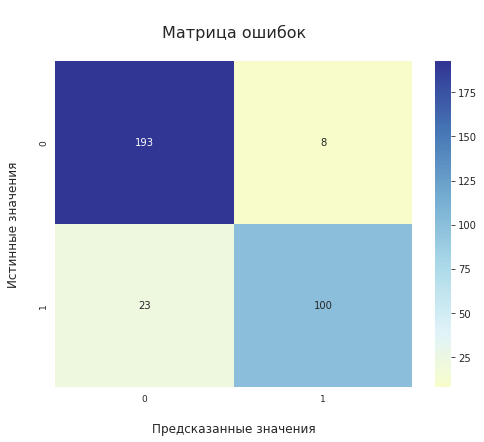

In [66]:
metrics(y_test, randomized_search.predict(X_test))

**Влияние признаков на предсказания модели**

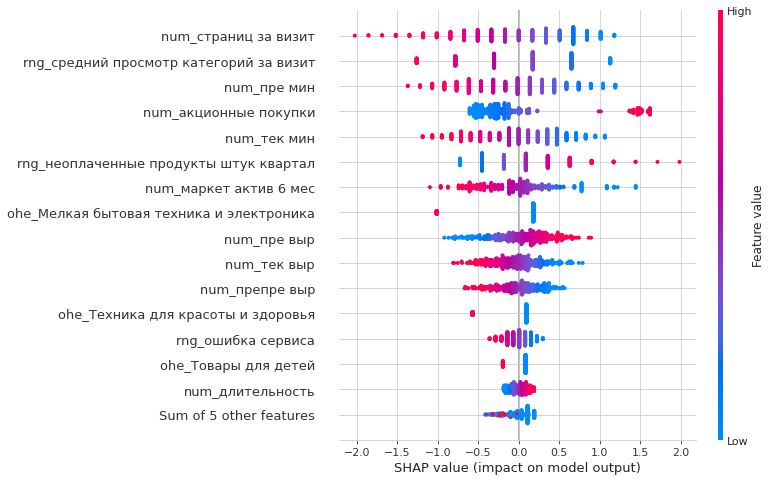

In [67]:
shap.plots.beeswarm(shap_values, max_display=16)

- наиболее значимыми признаками для модели являются: среднее количество страниц и просмотренных категорий за визит, а также время, проведенное на сайте
- при увеличении выручки вероятность снижения активности также увеличивается
- возникающие на сайте ошибки не влияют на активность пользователей
- не все пользователи имеют одинаковый шаблон поведения, что и приводит к ошибкам модели


### Анализ сегмента пользователей

Для анализа был выбран сегмент пользователей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Для повышения покупательской активности данного сегмента пользователей можно:
- чаще обновлять ассортимент акционных товаров
- создать отдельную страницу для таких товаров